Logistic Regression
- Explore the differences between batch and stochastic gradient descent
- Implement K-Folds Cross-Validation


In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('./stroke_data.csv')

In [2]:
#find and fill null values with averages (BMI has 201 null values)
avg = data['bmi'].mean()
data.bmi = (data.bmi.fillna(avg))

#### Give numerical values to categorical variables

<table>
    <thead>
        <tr>
            <th colspan=2>work_type</th>
            <th colspan=2>gender</th>
            <th colspan=2>Residence_type</th>
            <th colspan=2>smoking_status</th>
            <th colspan=2>ever_married</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Private</td>
            <td>0</td>
            <td>Male</td>
            <td>0</td>
            <td>Urban</td>
            <td>0</td>
            <td>formerly smoked</td>
            <td>0</td>
            <td>Yes</td>
            <td>0</td>
        </tr>
        <tr>
            <td>Self-employed</td>
            <td>1</td>
            <td>Female</td>
            <td>1</td>
            <td>Rural</td>
            <td>1</td>
            <td>never smoked</td>
            <td>1</td>
            <td>No</td>
            <td>1</td>
        </tr>
        <tr>
            <td>Govt_job</td>
            <td>2</td>
            <td>smokes</td>
            <td>2</td>
        </tr>
        <tr>
            <td>children</td>
            <td>3</td>
            <td>Unknown</td>
            <td>3</td>
        </tr>
        <tr>
            <td>Never_worked</td>
            <td>4</td>
        </tr>
    </tbody>
</table>

In [3]:
data['work_type'] = data['work_type'].map(
    {'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})
data['Residence_type'] = data['Residence_type'].map({'Urban': 0, 'Rural': 1})
data['smoking_status'] = data['smoking_status'].map(
    {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
data['ever_married'] = data['ever_married'].map({'Yes': 0, 'No': 1})

In [4]:
#divide dataset into features and labels
#drop ID because it's not necessary for analysis
X = data[
    ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'gender',
     'work_type', 'smoking_status']]
y = data['stroke']

In [5]:
#replace null values again (1 in gender)
X.gender = (X.gender.fillna(1))

/Users/kevinkarnani/.conda/envs/myenv/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Standardize data

In [6]:
#Standardizes the data using the mean and standard deviation
mean = np.mean(X, axis=0)
std = np.std(X, axis=0, ddof=1)
s_X = (X - mean) / std

#add bias feature
bias = (np.ones((s_X.shape[0], 1)))
s_X = np.append(s_X, bias, axis=1)

#### Handle Imbalanced Data

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
s_X, y = smote.fit_resample(s_X, y)

#### Split the dataset into train and test

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(s_X, y, test_size=0.33, random_state=0)

In [9]:
import random
import math

#Initialize the parameters of θ using random values in the range [-1, 1]
random.seed(0)
thetas = np.random.uniform(-1, 1, 11)

#variables 
n = 0.01  #learning rate
count = pd.DataFrame()
percent_change = 1
count_num = 1
cost = 1
m = X_train.shape[0]
#y_train = y_train.to_numpy()

### Functions

In [1]:
def sigmoid(x, thetas):
    return (1 / (1 + math.e ** -(x @ thetas)))


def gradient(X_train, y_train, thetas):
    sig = sigmoid(X_train, thetas)
    gradient = (X_train.T @ (sig - y_train))
    return gradient


#predictions
def prediction(y_test, X_test, thetas):
    size_test = y_test.shape[0]
    predictions = np.zeros(size_test)
    TP = FP = TN = FN = accuracy = 0

    #find probability for 1 and 0
    for a in range(size_test):
        p_1 = 1 / (1 + math.e ** -(X_test[a] @ thetas))
        p_0 = 1 - p_1
        if (p_1 > p_0):
            predictions[a] = 1
        else:
            predictions[a] = 0

    #find TP, FP, TN, FN
    for a in range(size_test):
        if (predictions[a] == 1):
            if (predictions[a] == y_test.iloc[a]):
                TP = TP + 1
                accuracy = accuracy + 1
            else:
                FP = FP + 1
        else:
            if (predictions[a] == y_test.iloc[a]):
                TN = TN + 1
                accuracy = accuracy + 1
            else:
                FN = FN + 1

    #precision, recall, f measure, accuracy
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = (2 * precision * recall) / (precision + recall)
    accuracy = accuracy / size_test

    print("Accuracy: ", accuracy * 100)
    print("Precision: ", precision * 100)
    print("Recall: ", recall * 100)
    print("F-measure: ", F1 * 100)
    print("TP: ", TP, "; FP: ", FP, "; TN: ", TN, "; FN: ", FN)


In [11]:
def logisticBGD(X_train, y_train, X_test, y_test, n, m):
    count_num = 0
    new_cost = 0
    percent_change = 1
    thetas = np.random.uniform(-1, 1, 11)
    #Terminate when absolute value change of loss on the data is
    #less than 2−23, or after 1500 iterations have passed (whichever occurs first).
    while (percent_change > (2 ** -23)):
        if (count_num == 1500):
            break

        #batch gradient descent
        thetas = thetas - ((n / m) * gradient(X_train, y_train, thetas))

        #cost
        total_cost = -np.sum((1 / m) * ((y_train * np.log(sigmoid(X_train, thetas) + epsilon)) + (1 - y_train) * np.log(
            1 - sigmoid(X_train, thetas) + epsilon)))

        #percent change
        percent_change = abs((new_cost - total_cost) / total_cost)
        new_cost = total_cost

        count_num = count_num + 1

    print("Thetas from batch gradient descent that minimize the loss function: ", thetas, "\n")
    prediction(y_test, X_test, thetas)


def logisticSGD(X_train, y_train, y_test, X_test, n, m):
    stoch_X_train = X_train
    stoch_y_train = y_train
    thetas = np.random.uniform(-1, 1, 11)
    new_cost = 1
    percent_change = 1
    count_num = 1

    #Terminate when absolute value change of loss on the data is less than 2−23, or after 1500 iterations have passed.
    while (percent_change > (2 ** -23)):
        if (count_num == 1500):
            break

        #stochastic gradient descent
        index = np.random.permutation(stoch_X_train.shape[0])
        stoch_X_train = np.take(stoch_X_train, index, axis=0)
        stoch_y_train = np.take(stoch_y_train, index, axis=0)
        thetas = thetas - ((n / m) * gradient(stoch_X_train, stoch_y_train, thetas))

        #cost
        total_cost = -np.sum(
            (1 / m) * (stoch_y_train * np.log(sigmoid(stoch_X_train, thetas) + epsilon)) + (1 - stoch_y_train) * np.log(
                1 - sigmoid(stoch_X_train, thetas) + epsilon))

        #percent change
        percent_change = abs((new_cost - total_cost) / total_cost)
        new_cost = total_cost
        count_num = count_num + 1

    print("Thetas from stochastic gradient descent that minimize the loss function: ", thetas, "\n")

    prediction(y_test, X_test, thetas)

#### Common Variables

In [12]:
random.seed(0)
n = 0.01  #learning rate
m = X_train.shape[0]
#y_train = y_train.to_numpy()
epsilon = 1e-5

#### Logistic Regression using Batch Gradient Descent

In [13]:
logisticBGD(X_train, y_train, X_test, y_test, n, m)

Thetas from batch gradient descent that minimize the loss function:  [ 1.19378526  0.14676987  0.15097408 -0.30370873 -0.04016311  0.09776613
  0.10330068 -0.03987798  0.22335362  0.15987371 -0.67633299] 

Accuracy:  77.37612963540043
Precision:  72.6487036095577
Recall:  88.37353123067409
F-measure:  79.74330357142857
TP:  1429 ; FP:  538 ; TN:  1054 ; FN:  188


#### Logistic Regression using Stochastic Gradient Descent

In [14]:
logisticSGD(X_train, y_train, y_test, X_test, n, m)

Thetas from stochastic gradient descent that minimize the loss function:  [ 0.84554574  0.19497869  0.18163035 -0.4562947  -0.12663161  0.26991537
 -0.31632375  0.064809   -0.18497486  0.0518967  -0.64756472] 

Accuracy:  77.43845434714865
Precision:  73.21892875715028
Recall:  87.07482993197279
F-measure:  79.54802259887006
TP:  1408 ; FP:  515 ; TN:  1077 ; FN:  209


#### Built-in function

Accuracy:  0.7877843564973512
Precision:  0.7656072644721907
Recall:  0.83426097711812
F-measure:  0.7984610831606985


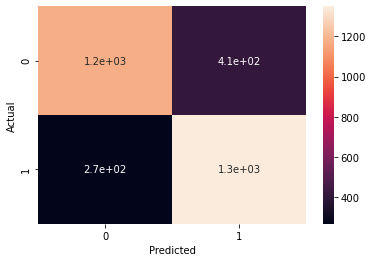

In [15]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred, zero_division=0))
print('Recall: ', metrics.recall_score(y_test, y_pred))
print('F-measure: ', metrics.f1_score(y_test, y_pred, zero_division=0))

plt.show()